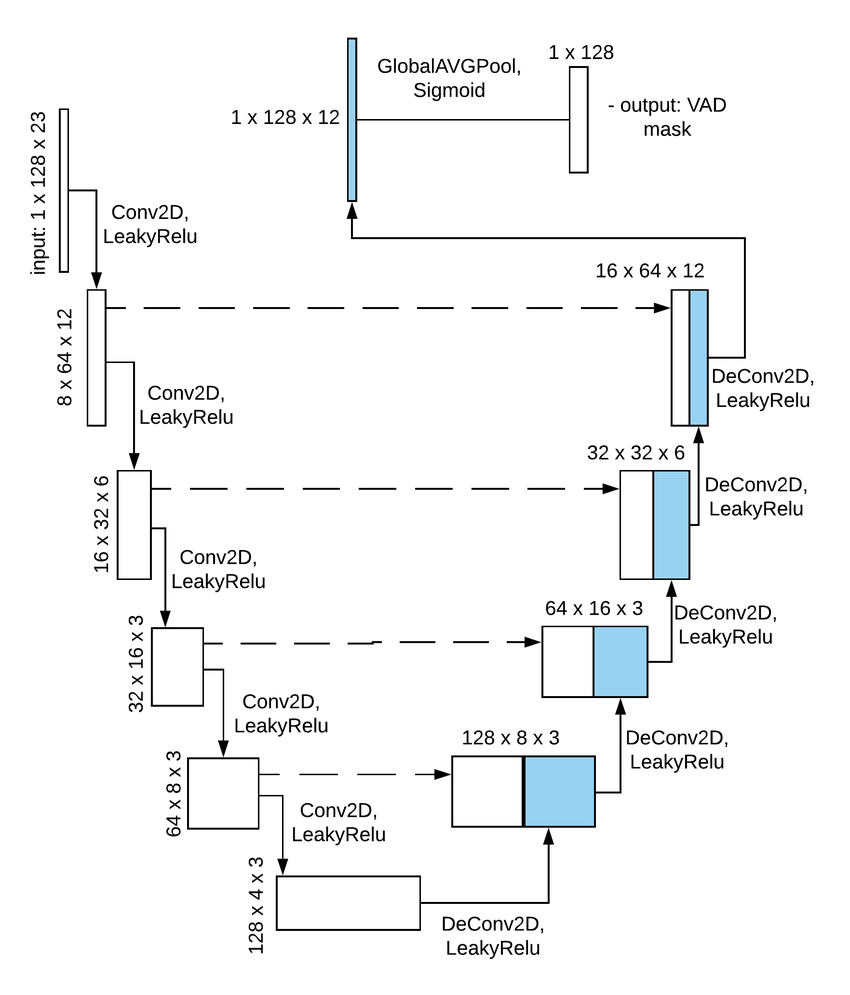


Picture taken from https://www.researchgate.net/publication/345141985_Deep_Speaker_Embeddings_for_Far-Field_Speaker_Recognition_on_Short_Utterances

# Global Paths

In [2]:
path_files = "drive/MyDrive/Master Thesis/"
path_python_files = path_files + 'Python_files'

# Imports

In [3]:
!pip install mlflow --quiet

     |████████████████████████████████| 15.6 MB 5.3 MB/s 
     |████████████████████████████████| 146 kB 61.8 MB/s 
     |████████████████████████████████| 210 kB 63.1 MB/s 
     |████████████████████████████████| 79 kB 9.2 MB/s 
     |████████████████████████████████| 58 kB 7.0 MB/s 
     |████████████████████████████████| 596 kB 52.1 MB/s 
     |████████████████████████████████| 181 kB 71.4 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 75 kB 5.4 MB/s 


In [20]:
# TODO
from datetime import datetime
import glob
import mlflow
import pandas as pd
import pickle
import pexpect
import random
import sys

from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.compat.v1.keras.initializers import he_uniform
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (
    ELU,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    LeakyReLU,
    Multiply,
    ReLU,
    Softmax,
)
from tensorflow.keras.utils import to_categorical

from typing import Dict, Any, Optional

In [5]:
# imports from own files
sys.path.append(path_python_files)
# configs for connecting to databricks
from configs_private import USERNAME, PASSWORD, EXPERIMENT_URL  # credentials for databricks
# helpful Enums
from Enums import AudioClipFileLength, FeatureType, RecPlace, SNR
# get the list of files per chosen SNR and RecPlace
from get_files import get_available_files
# get standardized parameters for feature extraction
from Parameters import Parameters
# extract the features and get the corresponding labels
from create_features_and_labels import get_feature_and_labels
# plot the distribution of files
from plot_files import plot_file_distribution
# get the standardized evaluation of the results
from evaluation_tensorflow import Evaluation

# Set values of Experiment
Set the different values depending on the type of experiment that should be run. When running a sweep of experiments, the values can be adjusted here.

In [6]:
snr = SNR.MINUS_FIVE  # SNR value of the current experiment
labels_per_frame = True  # otherwise labels per window
# Type of feature, either raw audio, MFCC, or Spectrogram
feature = FeatureType.MFCC
# if True, ignores raw audio during feature extraction to reduce memory needed
# only needed if raw_audio is feature of model is Wav2vec
ignore_raw_audio = False
# Number of epochs to train on
train_epochs = 10
# split between train and validation set
validation_split = 0.3
# Batch size of the training
batch_size = 32
# If the model should stop early if it is not improving
early_stopping = False
# number of epochs it will wait before stopping early
patience = 10
# optimizer used to train the model (default for all models is Adam)
optimizer='Adam'
# loss function (default is BinaryCrossEntropy, but Hingeloss was also tried)
loss='BinaryCrossentropy'

# Metrics on which to judge the model
metrics = ['accuracy']
# if save_best, the best trained epoch is loaded after training
save_best = True

# number of files for training/testing, can be set to reduce memory
# all files are shuffled before, so it will be split over all categories
nr_train_files = 30
nr_test_files = 30

# Connect to track results
Currently using the databricks community edition to track experiments

In [7]:
# Databricks community version does not allow token generation so instead 
# automatically insert the username and password using expect
child = pexpect.spawn('databricks configure --host https://community.cloud.databricks.com', encoding='utf-8')
child.expect('Username:')
child.sendline(USERNAME)
child.expect('Password:')
child.sendline(PASSWORD)
child.expect('Repeat for confirmation:')
child.sendline(PASSWORD)
print('Connected to Databricks')

Connected to Databricks


In [8]:
mlflow.set_tracking_uri("databricks")
# Create one Experiment per SNR value (from n-20dB to n+05dB in steps of 5)
mlflow.set_experiment(EXPERIMENT_URL+snr.value)

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1010535410834463', experiment_id='1010535410834463', lifecycle_stage='active', name='/Users/d.hamandouche@students.uu.nl/n-05', tags={'mlflow.experiment.sourceName': '/Users/d.hamandouche@students.uu.nl/n-05',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'd.hamandouche@students.uu.nl',
 'mlflow.ownerId': '6054914286087382'}>

In [9]:
mlflow.tensorflow.autolog()
# log the model name and featuretype as additional parameters
mlflow.log_param("model", "U-net")
mlflow.log_param("Feature", feature)

2022/02/23 01:56:34 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


# Get data

In [10]:
wav_files_train = get_available_files(path_files+"QUT-NOISE-TIMIT-new/", snr, AudioClipFileLength.ONE_MINUTE, rec_place=RecPlace.a)
wav_files_test = get_available_files(path_files+"QUT-NOISE-TIMIT-new/", snr, AudioClipFileLength.ONE_MINUTE, rec_place=RecPlace.b)

Total length: 900
Total length: 900


In [11]:
# Shuffle the list of audio files to avoid having just one category
random.shuffle(wav_files_train)
random.shuffle(wav_files_test)

In [12]:
# set all parameters as wanted
parameter = Parameters()
# set_params_specs is the default for Spectrogram
if feature == FeatureType.SPECTROGRAM or feature == FeatureType.RAW_AUDIO:
    print('Using spectrogram or raw audio parameter')
    parameter.set_params_specs()
else:
    print('Using MFCC parameter')
    parameter.set_params_unet()
parameter

Using MFCC parameter


Parameters(window_size=400, sliding_window_size=40960, hop_length=320, n_mfcc=32, n_mels=40, n_fft=400, fmin=0, fmax=None, sr=16000, htk=False, center=True, wiener_filters=12, use_wiener_filter=False, feature_type=<FeatureType.MFCC: 'MFCC'>)

# Train

## Extract Features

100%|██████████| 30/30 [00:37<00:00,  1.26s/it]


Counter({'n-05': 30})
Counter({1: 92098, 0: 84542})
Counter({'sA': 30})
Counter({'CAFE-CAFE-2': 5, 'HOME-KITCHEN-2': 4, 'CAFE-FOODCOURTB-2': 3, 'REVERB-CARPARK-2': 3, 'STREET-CITY-2': 3, 'CAFE-CAFE-1': 2, 'CAR-WINDOWNB-2': 2, 'HOME-LIVINGB-2': 1, 'STREET-CITY-1': 1, 'CAR-WINUPB-2': 1, 'CAR-WINDOWNB-1': 1, 'STREET-KG-1': 1, 'HOME-KITCHEN-1': 1, 'CAFE-FOODCOURTB-1': 1, 'HOME-LIVINGB-1': 1})


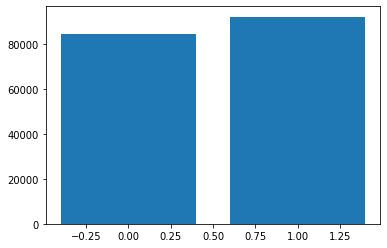

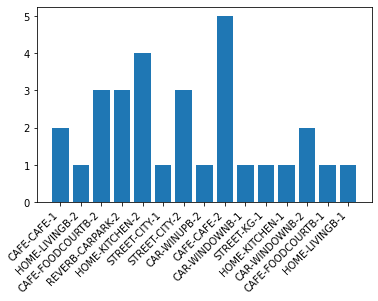

In [12]:
end_train = nr_train_files  # len(wav_files_train)
x_train, labels_train, frames_pos_train, _ = get_feature_and_labels(wav_files_train[0:end_train], parameter, ignore_raw_audio=ignore_raw_audio)
y_train = to_categorical(labels_train)
plot_file_distribution(wav_files_train[0:end_train], labels_train)

In [13]:
# transpose to get the shape (<samples>, 128, 32)
x_train = x_train.transpose(0,2,1)

## Model

U-net Model which can be used for spectrogram and MFCC input

In [14]:
if feature == FeatureType.SPECTROGRAM:
    shape=(128, parameter.n_mels, 1)
else:
    shape=(128, parameter.n_mfcc, 1)

input_tensor = layers.Input(shape=shape)
conv_n_filters = [8, 16, 32, 64, 128]
conv2d_factory = partial(
        Conv2D, strides=(2, 2), padding="same", kernel_initializer=he_uniform(seed=50)
    )
# First layer.
conv1 = conv2d_factory(conv_n_filters[0], (5, 5))(input_tensor)
batch1 = BatchNormalization(axis=-1)(conv1)
rel1 = LeakyReLU(0.3)(batch1)

# Second layer.
conv2 = conv2d_factory(conv_n_filters[1], (5, 5))(rel1)
batch2 = BatchNormalization(axis=-1)(conv2) 
rel2 = LeakyReLU(0.3)(batch2)

# Third layer.
conv3 = conv2d_factory(conv_n_filters[2], (5, 5))(rel2)
batch3 = BatchNormalization(axis=-1)(conv3)
rel3 = LeakyReLU(0.3)(batch3)

# Fourth layer.
conv4 = conv2d_factory(conv_n_filters[3], (5, 5))(rel3)
batch4 = BatchNormalization(axis=-1)(conv4)
rel4 = LeakyReLU(0.3)(batch4)

# Fifth layer
conv5 = conv2d_factory(conv_n_filters[4], (5, 5))(rel4)
batch5 = BatchNormalization(axis=-1)(conv5)

conv2d_transpose_factory = partial(
    Conv2DTranspose,
    strides=(2, 2),
    padding="same",
    kernel_initializer=he_uniform(seed=50),
)

# right side of Unet going back up
up1 = conv2d_transpose_factory(conv_n_filters[3], (5, 5))((batch5))
up1 = LeakyReLU(0.3)(up1)
batchu1 = BatchNormalization(axis=-1)(up1)
drop1 = Dropout(0.5)(batchu1)

# merge with previous side
merge1 = Concatenate(axis=-1)([conv4, drop1])

up2 = conv2d_transpose_factory(conv_n_filters[2], (5, 5))((merge1))
up2 = LeakyReLU(0.3)(up2)
batchu2 = BatchNormalization(axis=-1)(up2)
drop2 = Dropout(0.5)(batchu2)
merge2 = Concatenate(axis=-1)([conv3, drop2])

up3 = conv2d_transpose_factory(conv_n_filters[1], (5, 5))((merge2))
up3 = LeakyReLU(0.3)(up3)
batchu3 = BatchNormalization(axis=-1)(up3)
drop3 = Dropout(0.5)(batchu3)
merge3 = Concatenate(axis=-1)([conv2, drop3])

up4 = conv2d_transpose_factory(conv_n_filters[0], (5, 5))((merge3))
up4 = LeakyReLU(0.3)(up4)
batchu4 = BatchNormalization(axis=-1)(up4)
# no dropout here to avoid not learning anything
merge4 = Concatenate(axis=-1)([conv1, batchu4])

up5 = conv2d_transpose_factory(1, (5, 5), strides=(2, 2))((merge4))
up5 = LeakyReLU(0.3)(up5)
batchu5 = BatchNormalization(axis=-1)(up5)
# Last layer to ensure initial shape reconstruction.
up6 = Conv2D(
    2,
    (4, 4),
    dilation_rate=(2, 2),
    activation="sigmoid",
    padding="same",
    kernel_initializer=he_uniform(seed=50),
)((batchu5))
output = Multiply(name="output")([up6, input_tensor])

class GlobalAvgPoolAcrossTime(layers.Layer):
    def __init__(self, **kwargs):
        super(GlobalAvgPoolAcrossTime, self).__init__(**kwargs)

    # (Batch_size, time, y, x, channels) -> (Batch_size, 1, y, x, channels)
    def call(self, inputs):
        return keras.backend.mean(inputs, axis=2, keepdims=True)

# use this to take mean across dimension 2 (the mfcc features)
# according to the paper of the original model, they used globalAvgPooling
# but that would also remove the last dimension (2 nodes for the ouput)
if labels_per_frame:
    output = GlobalAvgPoolAcrossTime()(output) 
    # (Batch_size, 128, 32, 2) -> (Batch_size, 128, 1, 2)
    # reshape it to remove 3rd dimension completely
    output = layers.Reshape(target_shape=(128, -1))(output)
else:
    output = layers.AveragePooling2D(data_format='channels_first')(output)
    output = layers.Flatten()(output)
    output = layers.Dense(500, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = layers.Dense(25, activation='relu')(output)
    output = layers.Dropout(0.2)(output)

output = layers.Dense(2, activation='softmax')(output)

model = keras.models.Model(input_tensor, output, name=f'Unet_{feature.value}')
model.summary()

Model: "Unet_MFCC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 16, 8)    208         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 16, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                          

## Compile and train model

In [16]:
model.compile(optimizer=optimizer, loss=loss, metrics = metrics)
time = datetime.now()
# create path for saving the results
model_path = f"{path_files}Models/{model.name}_{snr.value}/{time}"
# add callbacks
callbacks = []
if early_stopping:
    # stop early with the given patience
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=patience)
    callbacks.append(callback)
if save_best:
    # save the best weights based on validation loss
    file_path = model_path + "/best_weights.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                monitor='val_loss', 
                                verbose=1, 
                                save_best_only=True, 
                                mode='min')
    callbacks.append(checkpoint)

# train the model
history = model.fit(x_train, y_train, epochs = train_epochs, 
                    batch_size=batch_size, validation_split=validation_split, 
                    verbose=1, callbacks=callbacks)

Epoch 1/10
31/31 [==============================] - ETA: 0s - loss: 0.8641 - accuracy: 0.5138
Epoch 1: val_loss improved from inf to 0.65908, saving model to drive/MyDrive/Master Thesis/Models/Unet_MFCC_n-05/2022-02-22 23:54:10.594249/best_weights.hdf5
31/31 [==============================] - 13s 76ms/step - loss: 0.8641 - accuracy: 0.5138 - val_loss: 0.6591 - val_accuracy: 0.6367
Epoch 2/10
30/31 [============================>.] - ETA: 0s - loss: 0.7123 - accuracy: 0.5847
Epoch 2: val_loss improved from 0.65908 to 0.55594, saving model to drive/MyDrive/Master Thesis/Models/Unet_MFCC_n-05/2022-02-22 23:54:10.594249/best_weights.hdf5
31/31 [==============================] - 1s 20ms/step - loss: 0.7117 - accuracy: 0.5855 - val_loss: 0.5559 - val_accuracy: 0.7592
Epoch 3/10
29/31 [===========================>..] - ETA: 0s - loss: 0.5809 - accuracy: 0.7035
Epoch 3: val_loss improved from 0.55594 to 0.54601, saving model to drive/MyDrive/Master Thesis/Models/Unet_MFCC_n-05/2022-02-22 23:54:

2022/02/22 23:54:45 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.1.71+cuda111) contains a local version label (+cuda111). MLflow logged a pip requirement for this package as 'jaxlib==0.1.71' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


## Save Results
Save the model as well as the weights and training history. In case the session crashes or needs to be restarted, the evaluation can still be performed with these elements

In [ ]:
model.save(model_path)
# get the best weights
best_weights = model_path + "/best_weights.hdf5"
# save the training history
with open(model_path + '/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history, file_pi)

# Evaluation

100%|██████████| 30/30 [00:36<00:00,  1.20s/it]


Counter({'n-05': 30})
Counter({0: 95169, 1: 81471})
Counter({'sB': 30})
Counter({'CAFE-FOODCOURTB-2': 4, 'STREET-CITY-2': 3, 'CAR-WINUPB-1': 3, 'STREET-CITY-1': 3, 'CAR-WINDOWNB-2': 3, 'HOME-LIVINGB-2': 2, 'CAR-WINDOWNB-1': 2, 'CAFE-CAFE-1': 2, 'REVERB-CARPARK-2': 2, 'HOME-KITCHEN-1': 2, 'CAR-WINUPB-2': 1, 'CAFE-CAFE-2': 1, 'HOME-LIVINGB-1': 1, 'CAFE-FOODCOURTB-1': 1})


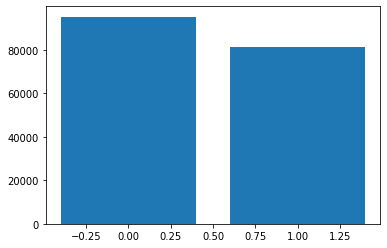

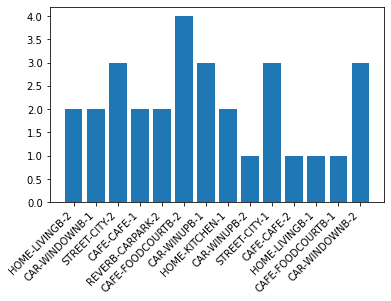

In [13]:
# if the training data still exists, remove it to reduce memory usage
# del x_train, y_train, frames_pos_train, labels_train
end_test = nr_test_files #len(wav_files_test)
# get the features and labels for the test set
x_test, labels_test, frames_pos_test, frames_test = get_feature_and_labels(wav_files_test[0:end_test], parameter, ignore_raw_audio=ignore_raw_audio)
y_test = to_categorical(labels_test)
if feature == FeatureType.RAW_AUDIO:
    # use the raw audio
    x_test = frames_test
x_test = x_test.transpose(0,2,1)  # transpose to get the shape (<samples>, 128, 32)
# plot the distribution of the test set
plot_file_distribution(wav_files_test[0:end_test], labels_test)

In [16]:
# get the model from the directory
model_name = 'Unet_MFCC'
model_path = f'{path_files}Models/{model_name}_{snr.value}/'
runs = glob.glob(model_path + '/2022*')
print(*runs,sep='\n')  # show each run in a new line
run = runs[-1]  # usually the last one is wanted as that is the newest one

drive/MyDrive/Master Thesis/Models/Unet_MFCC_n-05/2022-01-18 17:21:54.069025
drive/MyDrive/Master Thesis/Models/Unet_MFCC_n-05/2022-01-21 17:40:53.754057
drive/MyDrive/Master Thesis/Models/Unet_MFCC_n-05/2022-02-22 23:54:10.594249


In [17]:
model = load_model(run)
best_weights = run + "/best_weights.hdf5"

In [18]:
history = pickle.load(open(run + '/trainHistoryDict', 'rb'))

44/44 [==============================] - 1s 5ms/step - loss: 0.1894 - accuracy: 0.9253


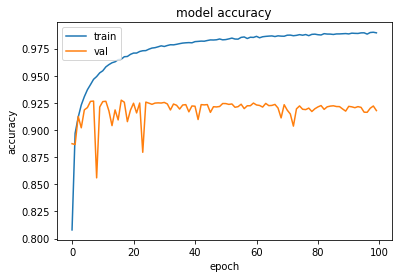

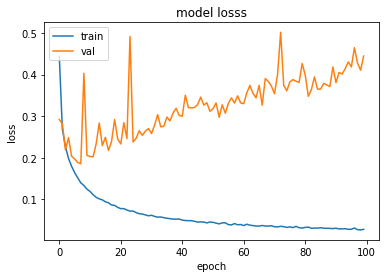

[[86861  8308]
 [ 4890 76581]]


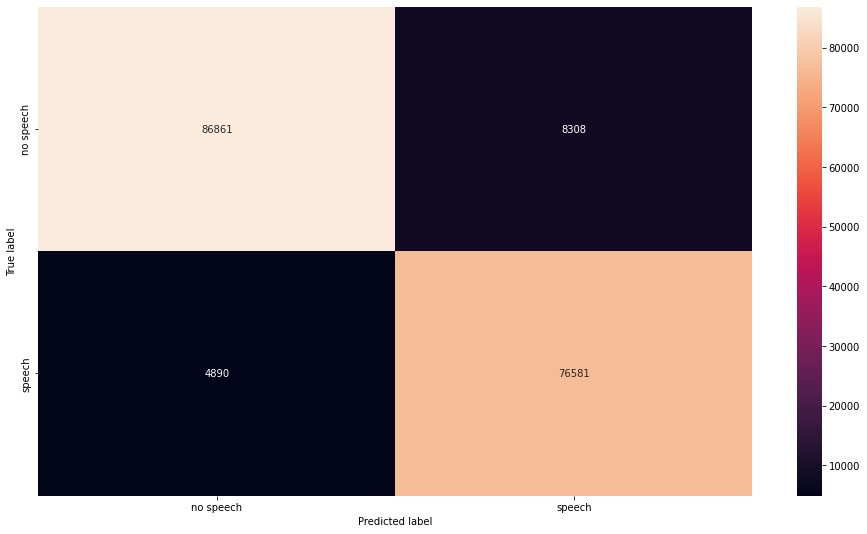

The HTER is 7.366% for SNR n-05, with MR being 6.002% and FAR being 8.730%
[[86874  8295]
 [ 4866 76605]]


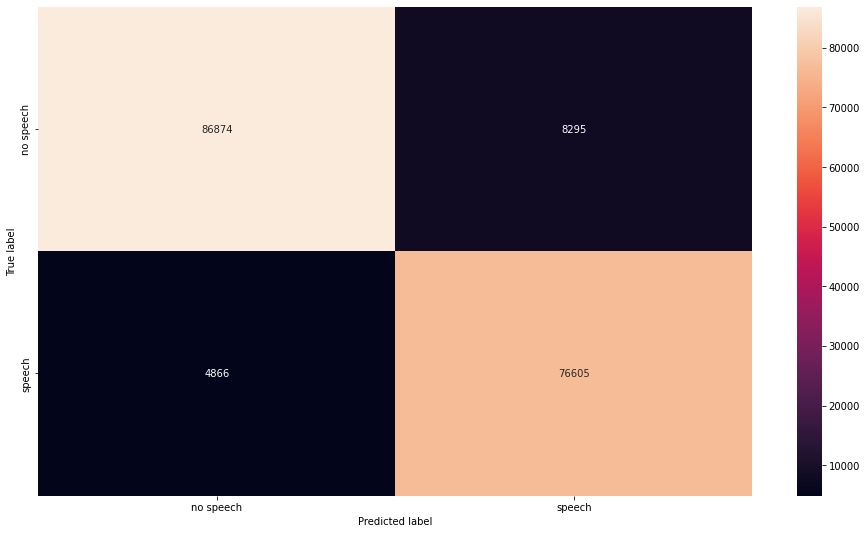

The post-processing HTER is 7.344% for SNR n-05, with MR being 5.973% and FAR being 8.716%


In [19]:
eval = Evaluation(model, run, history, x_test, y_test, snr, parameter, 
                  model_name, best_weights, save_figures=True)
eval.evaluate()

# Display Example

In [21]:
def read_random_file():
    """
    Read a random file which contains speech
    """
    attempt = 0
    while attempt < 5:
        example_file = random.randint(0, len(wav_files_test))
        print(example_file)
        filename = wav_files_test[example_file]
        print(filename)
        eventlab = filename.replace(".wav", ".eventlab")
        df = pd.read_csv(eventlab, sep=" ", header=None)
        df = df.loc[df[2] == 'speech'].copy()
        if len(df) >= 1:
            return filename
        attempt += 1
    return wav_files_test[0]

In [22]:
filename = read_random_file()

51
drive/MyDrive/Master Thesis/QUT-NOISE-TIMIT-new/CAFE-CAFE-1/sB/l060/n-05/CAFE-CAFE-1_sB_l060_n-05_i54300_x657e4.wav


In [25]:
x_example, labels_example, frames_pos_example, frames_example = get_feature_and_labels([filename], parameter)
y_example = to_categorical(labels_example)
x_example = x_example.transpose(0, 2, 1)

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


In [27]:
preds = model.predict(x_example)

2/2 [==============================] - 0s 9ms/step - loss: 0.3255 - accuracy: 0.8546


In [ ]:
def convert_preds_to_audio(predictions: np.ndarray, frame_positions: List[Dict[str, int]], audio_len):
    complete_predictions = [-1] * audio_len
    for row in range(predictions.shape[0]):
        lower = frame_positions[row]['lower']
        upper = frame_positions[row]['upper']
        complete_predictions[lower: upper] = [predictions[row]] * (upper-lower)
    complete_predictions = np.array(complete_predictions)
    return complete_predictions

In [ ]:
preds = np.argmax(preds, axis=2)
pred_flat = preds.reshape(-1)
labels_flat = labels_example.reshape(-1)

In [ ]:
complete_preds = convert_preds_to_audio(pred_flat, frames_pos_example, 960001)

In [ ]:
labels_complete = convert_preds_to_audio(labels_flat, frame_pos, 960001)

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import librosa
fig = figure(figsize=(15, 10), dpi=80)
audio, sr = librosa.load(filename, sr=16000)
plt.plot(audio)
plt.plot(complete_preds, label='Predicted')

plt.plot(labels_complete* -1, label='True')

plt.legend()
if save_fig:
    plt.savefig(model_path + f'/{filename.split("/")[-1].split(".")[0]}.png')
plt.show()